In [1]:
import sys
import config
sys.path.append(config.root)
sys.path.append(config.root+'/model')
sys.path.append(config.root+'/trainer')
import glob
import numpy as np
import torch
import time
import random
import torch.nn as nn
import matplotlib.pyplot as plt
from seg_model.unet import unet
from utils.metric import oa_binary, miou_binary
from utils.plot_dset_one import plot_dset_one
from dataloader.read_preprocess import read_preprocess
from seg_model.deeplabv3_plus import deeplabv3plus, deeplabv3plus_imp
from dataloader.loader import patch_tensor_dset
from dataloader.parallel_loader import parallel_load_dset

In [2]:
# ------------Device---------------- #
device = torch.device('cuda:0')

# ------------Data paths-------------- #
# ---scene path---
paths_as = sorted(glob.glob(config.root+'/data/s1_ascend/*'))
paths_des = sorted(glob.glob(config.root+'/data/s1_descend/*'))
paths_truth = sorted(glob.glob(config.root+'/data/s1_truth/*'))
# ---patch path---
paths_patch_test = sorted(glob.glob(config.root+'/data/test_patches/*'))
#----------setting------- #
torch.manual_seed(999)   # make the trianing replicable
random.seed(1099)        # make the data augmentation replicable


In [3]:
'''---------data loading--------'''
### ------training data loading through parallel pipeline----- ### 
scene_list, truth_list = read_preprocess(paths_as=paths_as, \
                                paths_des=paths_des, paths_truth=paths_truth)
tra_dset = parallel_load_dset(scene_list[0:15], \
                                truth_list[0:15], num_thread=30)
### -----test data loading from prepared test patches------ ###
patch_list_test = [torch.load(path) for path in paths_patch_test]
test_dset = patch_tensor_dset(patch_pair_list=patch_list_test)
### -------print-------###
print('size of training data:', tra_dset.__len__())
print('size of test data:', test_dset.__len__())


size of training data: 450
size of test data: 250


In [4]:
tra_loader = torch.utils.data.DataLoader(tra_dset, \
                                batch_size=config.batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dset, \
                                batch_size=config.batch_size)



In [5]:
### Configuration
# model = unet(num_bands=4, num_classes=2).to(device)
# model = deeplabv3plus(num_bands=4, num_classes=2).to(device)
model = deeplabv3plus_imp(num_bands=4, num_classes=2).to(device)
# loss_ce = nn.CrossEntropyLoss()
loss_bce = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=config.lr)
lr_scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer,\
                                        mode='min', factor=0.5, patience=10)


In [6]:
'''------train step------'''
def train_step(model, loss_fn, optimizer, x, y):
    optimizer.zero_grad()
    pred = model(x)
    loss = loss_fn(pred, y.float())
    loss.backward()
    optimizer.step()
    miou = miou_binary(pred=pred, truth=y)
    oa = oa_binary(pred=pred, truth=y)
    return loss, miou, oa

'''------test step------'''
def test_step(model, loss_fn, x, y):
    model.eval()
    with torch.no_grad():
        pred = model(x)
        loss = loss_fn(pred, y.float())
    miou = miou_binary(pred=pred, truth=y)
    oa = oa_binary(pred=pred, truth=y)
    return loss, miou, oa

'''------train loops------'''
def train_loops(model, loss_fn, optimizer, tra_loader, test_loader, epoches, lr_scheduler):

    size_tra_loader = len(tra_loader)
    size_test_loader = len(test_loader)
    for epoch in range(epoches):
        start = time.time()
        tra_loss, test_loss = 0, 0
        tra_miou, test_miou = 0, 0
        tra_oa, test_oa = 0, 0
        '''-----train the model-----'''
        time_dataread = []
        time_train = []
        for x_batch, y_batch in tra_loader:
            x_batch, y_batch = [batch.to(device) for batch in x_batch], y_batch.to(device)
            x_batch = x_batch[2]    #!!!note: x_batch[2] for single-scale model
            loss, miou, oa = train_step(model=model, loss_fn=loss_fn, 
                                    optimizer=optimizer, x=x_batch, y=y_batch)
            tra_loss += loss.item()
            tra_miou += miou.item()
            tra_oa += oa.item()
        lr_scheduler.step(tra_loss)  # dynamic adjust learning rate
        '''-----test the model-----'''
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = [batch.to(device) for batch in x_batch], y_batch.to(device)            
            x_batch = x_batch[2]   #!!!note: x_batch[2] for single-scale model
            loss, miou, oa = test_step(model=model, loss_fn=loss_fn, 
                                    x=x_batch, y=y_batch)
            test_loss += loss.item()
            test_miou += miou.item()
            test_oa += oa.item()
        ## Accuracy
        tra_loss = tra_loss/size_tra_loader
        test_loss = test_loss/size_test_loader
        tra_miou = tra_miou/size_tra_loader
        test_miou = test_miou/size_test_loader
        tra_oa = tra_oa/size_tra_loader
        test_oa = test_oa/size_test_loader
        format = 'Ep{}: tra-> Loss:{:.3f},Oa:{:.2f},Miou:{:.2f}, test-> Loss:{:.2f},Oa:{:.2f},Miou:{:.2f},time:{:.0f}s'
        print(format.format(epoch+1, tra_loss, tra_oa, tra_miou, test_loss, test_oa, test_miou, time.time()-start))
        if (epoch+1)%10 == 0:
            model.eval()
            sam_index = random.randrange(len(test_dset))
            patches, truth = test_dset[sam_index]
            patches = [torch.unsqueeze(patch, 0).to(device) for patch in patches]
            truth = truth.to(device)
            pred = model(patches[2])   #!!!note: x[2] for single-scale model
            patches = [patch[0].to('cpu').detach().numpy().transpose(1,2,0) for patch in patches]
            pred = pred[0].to('cpu').detach().numpy()
            truth = truth.to('cpu').detach().numpy()
            plt.figure(figsize=(12,5))
            plot_dset_one(inputs=patches, truth=truth, pre=pred, binary_out=True, weights=None)

Ep1: tra-> Loss:0.365,Oa:0.83,Miou:0.73, test-> Loss:0.44,Oa:0.90,Miou:0.64,time:18s
Ep2: tra-> Loss:0.380,Oa:0.84,Miou:0.62, test-> Loss:0.24,Oa:0.87,Miou:0.78,time:16s
Ep3: tra-> Loss:0.193,Oa:0.92,Miou:0.85, test-> Loss:0.31,Oa:0.88,Miou:0.73,time:16s
Ep4: tra-> Loss:0.200,Oa:0.91,Miou:0.85, test-> Loss:0.22,Oa:0.88,Miou:0.80,time:16s
Ep5: tra-> Loss:0.182,Oa:0.92,Miou:0.86, test-> Loss:0.22,Oa:0.88,Miou:0.79,time:16s
Ep6: tra-> Loss:0.179,Oa:0.92,Miou:0.86, test-> Loss:0.21,Oa:0.89,Miou:0.81,time:16s
Ep7: tra-> Loss:0.177,Oa:0.92,Miou:0.86, test-> Loss:0.23,Oa:0.88,Miou:0.79,time:16s
Ep8: tra-> Loss:0.164,Oa:0.93,Miou:0.86, test-> Loss:0.23,Oa:0.87,Miou:0.78,time:16s
Ep9: tra-> Loss:0.159,Oa:0.93,Miou:0.87, test-> Loss:0.35,Oa:0.86,Miou:0.72,time:16s
Ep10: tra-> Loss:0.234,Oa:0.90,Miou:0.82, test-> Loss:0.21,Oa:0.88,Miou:0.80,time:16s


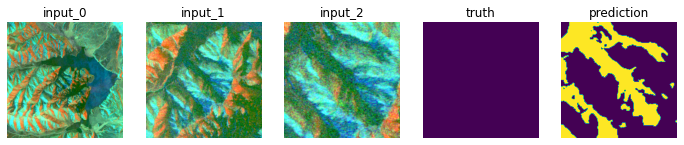

Ep11: tra-> Loss:0.152,Oa:0.93,Miou:0.87, test-> Loss:0.24,Oa:0.88,Miou:0.81,time:16s
Ep12: tra-> Loss:0.153,Oa:0.93,Miou:0.88, test-> Loss:0.25,Oa:0.88,Miou:0.81,time:16s
Ep13: tra-> Loss:0.186,Oa:0.92,Miou:0.85, test-> Loss:0.24,Oa:0.87,Miou:0.77,time:16s
Ep14: tra-> Loss:0.150,Oa:0.94,Miou:0.88, test-> Loss:0.24,Oa:0.88,Miou:0.81,time:16s
Ep15: tra-> Loss:0.148,Oa:0.92,Miou:0.87, test-> Loss:0.22,Oa:0.88,Miou:0.81,time:16s
Ep16: tra-> Loss:0.180,Oa:0.92,Miou:0.86, test-> Loss:0.26,Oa:0.86,Miou:0.73,time:16s
Ep17: tra-> Loss:0.170,Oa:0.92,Miou:0.87, test-> Loss:0.24,Oa:0.88,Miou:0.80,time:16s
Ep18: tra-> Loss:0.162,Oa:0.93,Miou:0.86, test-> Loss:0.30,Oa:0.85,Miou:0.70,time:16s
Ep19: tra-> Loss:0.184,Oa:0.92,Miou:0.86, test-> Loss:0.22,Oa:0.88,Miou:0.80,time:16s


In [7]:
train_loops(model=model, 
            loss_fn=loss_bce, 
            optimizer=optimizer,
            tra_loader=tra_loader, 
            test_loader=test_loader, 
            epoches=config.epoch,
            lr_scheduler=lr_scheduler)


In [8]:
### model save/load
# model_weights = config.root + '/model/pretrained/unet_weights.pt'
# torch.save(model.state_dict(), model_weights)
# model.load_state_dict(torch.load(model_weights))


